> From the PO.DAAC Cookbook, to access the GitHub version of the notebook, follow [this link](https://github.com/podaac/tutorials/blob/master/notebooks/datasets/OPERA_GIS_Notebook.ipynb).

# Working with OPERA Dynamic Surface Water Extent (DSWx) Data:
## Local Machine Download Version

#### *Author: Nicholas Tarpinian, PO.DAAC*

## Summary & Learning Objectives
### Notebook showcasing how to work with OPERA DSWx data on a local machine
- Utilizing the earthaccess Python package. For more information visit: https://nsidc.github.io/earthaccess/
- Option to query the new dataset based on users choice; either by classified layer 'B01' or sensor ('L8_30_v1.0_B01_WTR'), etc.
- Visualizing the dataset based on its classified layer values.
- Mosaicking multiple layers into a single GeoTIFF file.

## Requirements

### 1. Compute environment 

This tutorial is written to run in the following environment:
- **Local compute environment** e.g. laptop, server: this tutorial can be run on your local machine

### 2. Earthdata Login

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up. 


### Import libraries

In [1]:
#from original notebook:
import requests
import json
import rasterio as rio
from rasterio.plot import show
from rasterio.merge import merge
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
from pathlib import Path
import os
from urllib.request import urlretrieve
from json import dumps
import earthaccess
from earthaccess import Auth, DataCollections, DataGranules, Store

## Authentication with earthaccess

In this notebook, we will be calling the authentication in the below cell.

In [ ]:
auth = earthaccess.login(strategy="interactive", persist=True)

### Search using `earthaccess` for OPERA DSWx
Each dataset has it's own unique collection concept ID. For the OPERA_L3_DSWX-HLS_PROVISIONAL_V1 dataset, we can find the collection ID [here](https://podaac.jpl.nasa.gov/dataset/OPERA_L3_DSWX-HLS_PROVISIONAL_V1).

For this tutorial, we are looking at the Lake Powell Reservoir.

We used [bbox finder](http://bboxfinder.com/) to get the exact coordinates for our area of interest.

We want to look at two different times for comparison: 04/11/2023 and 05/02/2023. To find these dates, let's search for all the data granules between the two.

In [4]:
#earthaccess data search
Query = DataGranules().concept_id("C2617126679-POCLOUD").bounding_box(-111.144811,36.980121,-110.250799,37.915625).temporal("2023-04-11T00:00:00","2023-05-02T23:59:59")
print(f"Granule hits: {Query.hits()}")

Granule hits: 50


From this search, we received 50 granules between 4/11/2023 and 05/02/2023.

In [7]:
#assign the 50 granules to a variable
granules = Query.get()

#Find the links for the timestamps
data_links = [g.data_links(access="on_prem") for g in granules]

#test output on first granule
data_links[0]

['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T12SWG_20230411T180222Z_20230414T030954Z_L8_30_v1.0_B01_WTR.tif',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T12SWG_20230411T180222Z_20230414T030954Z_L8_30_v1.0_B02_BWTR.tif',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T12SWG_20230411T180222Z_20230414T030954Z_L8_30_v1.0_B03_CONF.tif',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T12SWG_20230411T180222Z_20230414T030954Z_L8_30_v1.0_B04_DIAG.tif',
 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T12SWG_20230411T180222Z_20230414T030954Z_L8_30_v1.0_B05_WTR-1.tif',
 'https://archive.podaac.earthdata.nasa.gov/p

OPERA has 10 different available layers. The data_links variable for the first granule resulted in 10 files, each representing a different layer in the dataset. We will only need one of these files.

### Get desired links

Let's get download links for the desired files. We want to query the dataset based on a specific classified layer 'B01' or sensor ('L8_30_v1.0_B01_WTR') as well as for the two dates (04/11/2023 and 05/02/2023).

We will look at 'B01_WTR' which is the Water Classification (WTR) layer of the OPERA DSWx dataset. Details on each available layer and the data product can be found [here](https://d2pn8kiwq2w21t.cloudfront.net/documents/ProductSpec_DSWX_URS309746.pdf).

In [8]:
#add the necessary data to a list, here we are looking for B01_WTR layer and two dates specified earlier
downloads_04112023 = []
downloads_05022023 = []
for r in data_links:
    for l in r:
        if 'B01_WTR' in l:
            if '20230411' in l:
                downloads_04112023.append(l)
            if '05022023' in l:
                downloads_05022023.append(l)

                
print(len(downloads_04112023))
print(len(downloads_05022023))

4
4


For the B01_WTR layer, each date has 4 files

### Download the Data into a folder

Since we are looking at two seperate times, we create two folder path names, one for each date, so we can mosaic all the files within one folder based on its respective time range later.

In [9]:
#download the files into folders
Store(auth).get(downloads_04112023, "./data_downloads/OPERA_041123")
Store(auth).get(downloads_05022023, "./data_downloads/OPERA_050223")

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

['OPERA_L3_DSWx-HLS_T12SWG_20230411T180222Z_20230414T030954Z_L8_30_v1.0_B01_WTR.tif',
 'OPERA_L3_DSWx-HLS_T12SVF_20230411T180222Z_20230414T030950Z_L8_30_v1.0_B01_WTR.tif',
 'OPERA_L3_DSWx-HLS_T12SVG_20230411T180222Z_20230414T030945Z_L8_30_v1.0_B01_WTR.tif',
 'OPERA_L3_DSWx-HLS_T12SWF_20230411T180222Z_20230414T031011Z_L8_30_v1.0_B01_WTR.tif']

Data should download into two folders seperated by date, each having four files.

### Visualizing the Dataset

Let's now visualize an individual layer for a single file that was downloaded using Rasterio to read the GeoTIFF image.

In [10]:
dsw = rio.open('data_downloads/OPERA_041123/OPERA_L3_DSWx-HLS_T12SVG_20230411T180222Z_20230414T030945Z_L8_30_v1.0_B01_WTR.tif')

OPERA is a single band image with specific classified rgb values.

This requires to read the single band, then creating a numpy array of the specified rgb values. e.g. 'variable'.colormap

In [11]:
image = dsw.read(1)
color_array = np.asarray(
    [dsw.colormap(1)[i] for i in range(256)], dtype=np.uint8)
dsw2 = color_array[image]

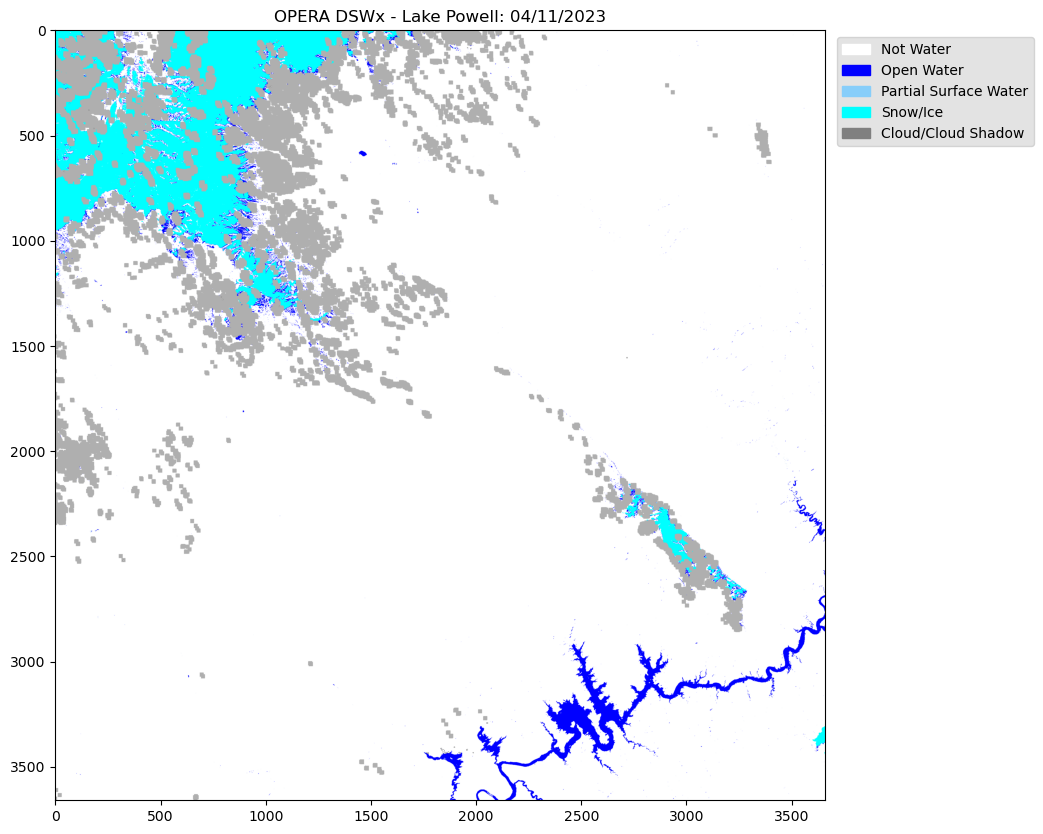

In [12]:
fig, ax = plt.subplots(figsize=(15,10))
plt.title("OPERA DSWx - Lake Powell: 04/11/2023")

#Legend based on specifed classified layer.
legend_labels = {"white":"Not Water", "blue":"Open Water", "lightskyblue":"Partial Surface Water", "cyan":"Snow/Ice", "grey":"Cloud/Cloud Shadow"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
ax.legend(handles=patches,
          bbox_to_anchor=(1.28, 1),
          facecolor="gainsboro")

plt.imshow(dsw2)
plt.show()

### Mosaic Multiple OPERA Layers

When creating a mosaic, make sure the temporal range is correct/matching. We define the output directory for the mosaic GeoTIFFs below.

The mosaic is being created because we have 4 results from the bounding box area provided. If you receive more than 1 result and would like to see a single raster image of all the results, mosaicking is the solution.

In [13]:
Path('data_downloads/mosaic_outputs').mkdir(parents=True, exist_ok=True)
output_path = 'data_downloads/mosaic_outputs'

We define a function to convert files per timestamp to mosaicked geoTIFFs. 

In [14]:
def raster2mosaic(data_folder, output_path, output_file_name):
    raster_files = list(data_folder.iterdir())
    raster_to_mosaic_list = [] #create empty list
    for p in raster_files:
        raster = rio.open(p)
        raster_to_mosaic_list.append(raster)
    mosaic, output = merge(raster_to_mosaic_list) #the merge function will mosaic the raster images
    #Then we update the raster's metadata to match the width and height of the mosaic
    output_meta = raster.meta.copy()
    output_meta.update(
        {"driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": output
        }
    )
    #Save the output in a new mosaicked raster image
    with rio.open(os.path.join(output_path, output_file_name), 'w', **output_meta) as m:
        m.write(mosaic)

In [15]:
#set data to a list for each of the two data sets
folder1 = Path("data_downloads/OPERA_041123")
folder2 = Path("data_downloads/OPERA_050223")

raster2mosaic(folder1, output_path, 'mosaic_041123.tif')
raster2mosaic(folder2, output_path, 'mosaic_050223.tif')

### Visualizing the Mosaic

Open the new mosaicked raster images individually with its respective paths.

In [16]:
mos1 = rio.open(os.path.join(output_path, 'mosaic_041123.tif'))
mos2 = rio.open(os.path.join(output_path, 'mosaic_050223.tif'))   

To visualize the mosaic, you must utilize the single layer colormap.

This will be the 'dsw' variable used earlier to visualize a single layer. Similarly reading the single band, then creating a numpy array of the specified rgb values. e.g. 'variable'.colormap

In [17]:
image2 = mos2.read(1)
color_array = np.asarray(
    [dsw.colormap(1)[i] for i in range(256)], dtype=np.uint8)
dsw4 = color_array[image2]

In [18]:
image1 = mos1.read(1)
color_array = np.asarray(
    [dsw.colormap(1)[i] for i in range(256)], dtype=np.uint8)
dsw3 = color_array[image1]

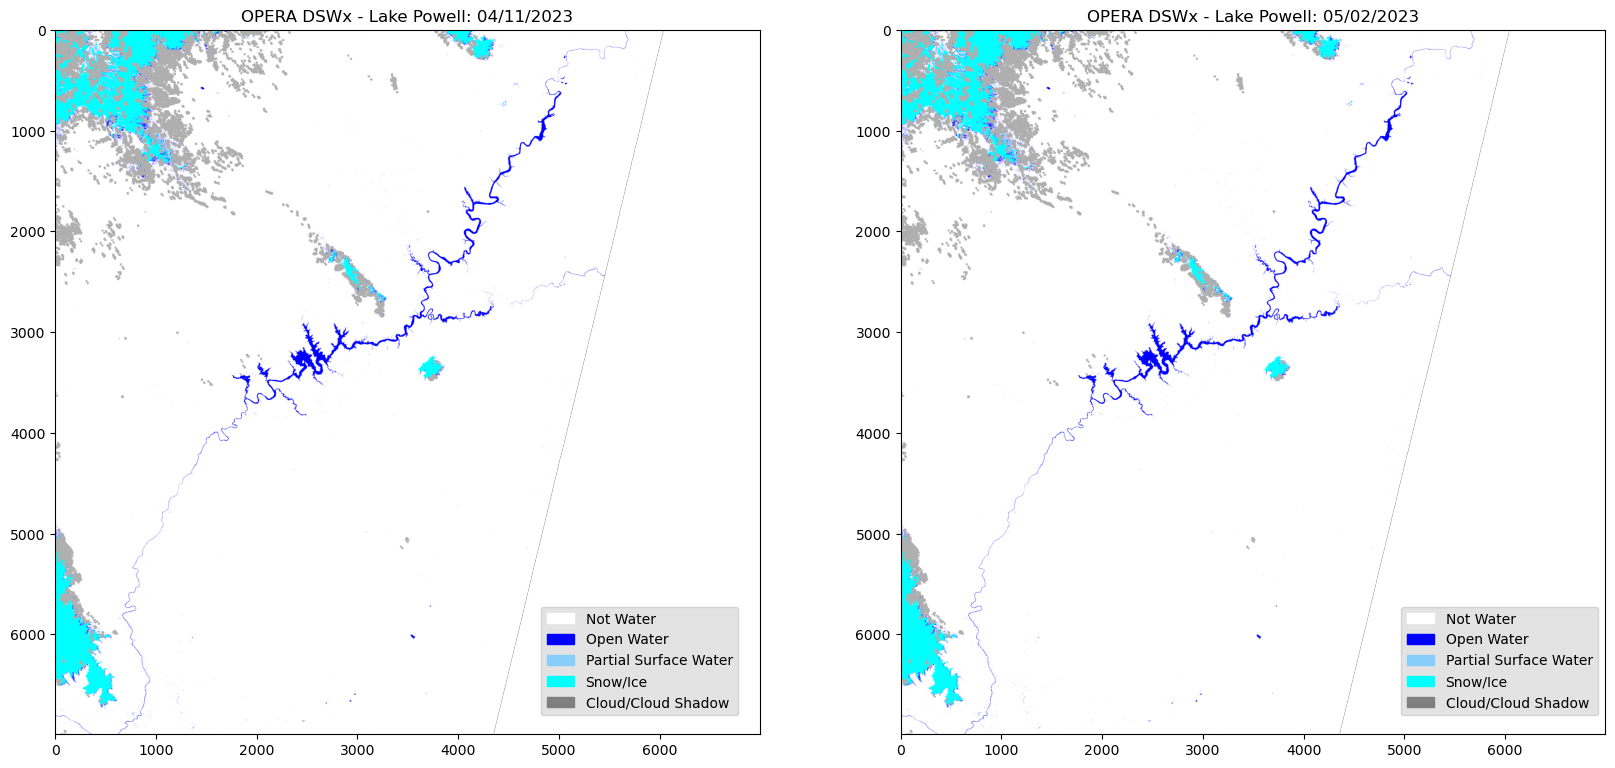

In [19]:
fig = plt.figure(figsize=(20, 15))

rows = 1
columns = 2

# Lake Powell 04/11/2023
fig.add_subplot(rows, columns, 1)
plt.title("OPERA DSWx - Lake Powell: 04/11/2023")
plt.imshow(dsw3)

#Legend based on specifed classified layer.
legend_labels = {"white":"Not Water", "blue":"Open Water", "lightskyblue":"Partial Surface Water", "cyan":"Snow/Ice", "grey":"Cloud/Cloud Shadow"}
patches = [Patch(color=color, label=label)
        for color, label in legend_labels.items()]
fig.legend(handles=patches,
        bbox_to_anchor=(0.47,0.35),
        facecolor="gainsboro")

# Lake Powell 05/02/2023
fig.add_subplot(rows, columns, 2)
plt.title("OPERA DSWx - Lake Powell: 05/02/2023")
plt.imshow(dsw4)

#Legend based on specifed classified layer.
legend_labels = {"white":"Not Water", "blue":"Open Water", "lightskyblue":"Partial Surface Water", "cyan":"Snow/Ice", "grey":"Cloud/Cloud Shadow"}
patches = [Patch(color=color, label=label)
        for color, label in legend_labels.items()]
fig.legend(handles=patches,
        bbox_to_anchor=(0.9, 0.35),
        facecolor="gainsboro")

plt.show()

### To take a closer look at a specific area of the image, we can create an inset map of a specified area.

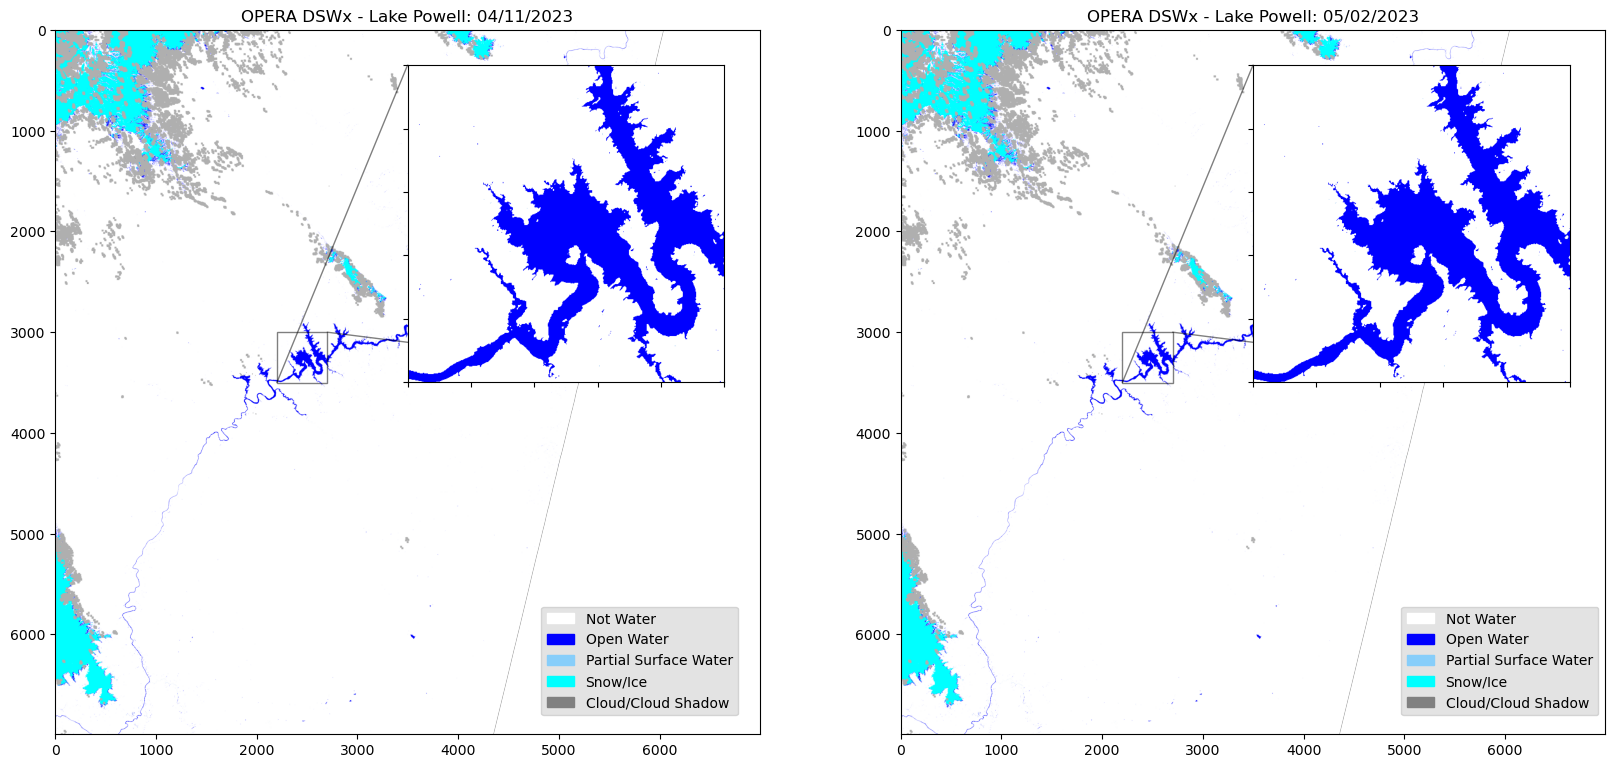

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))

ax[0].imshow(dsw3)
ax[0].set_title("OPERA DSWx - Lake Powell: 04/11/2023")

legend_labels = {"white":"Not Water", "blue":"Open Water", "lightskyblue":"Partial Surface Water", "cyan":"Snow/Ice", "grey":"Cloud/Cloud Shadow"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
fig.legend(handles=patches,
          bbox_to_anchor=(0.47,0.35),
          facecolor="gainsboro")

ax_ins1 = ax[0].inset_axes([0.5, 0.5, 0.45, 0.45])
ax_ins1.imshow(dsw3)

x1, x2, y1, y2 = 2200, 2700, 3500, 3000 #Extent set for aoi of inset map.
ax_ins1.set_xlim(x1, x2)
ax_ins1.set_ylim(y1, y2)
ax_ins1.set_xticklabels('')
ax_ins1.set_yticklabels('')

ax[0].indicate_inset_zoom(ax_ins1, edgecolor='black')

ax[1].imshow(dsw4)
ax[1].set_title("OPERA DSWx - Lake Powell: 05/02/2023")

legend_labels = {"white":"Not Water", "blue":"Open Water", "lightskyblue":"Partial Surface Water", "cyan":"Snow/Ice", "grey":"Cloud/Cloud Shadow"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
fig.legend(handles=patches,
          bbox_to_anchor=(0.9, 0.35),
          facecolor="gainsboro")

ax_ins2 = ax[1].inset_axes([0.5, 0.5, 0.45, 0.45])
ax_ins2.imshow(dsw4)

x1, x2, y1, y2 = 2200, 2700, 3500, 3000 #Extent set for aoi of inset map.
ax_ins2.set_xlim(x1, x2)
ax_ins2.set_ylim(y1, y2)
ax_ins2.set_xticklabels('')
ax_ins2.set_yticklabels('')

ax[1].indicate_inset_zoom(ax_ins2, edgecolor='black')

plt.show()
